In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy.optimize import bisect
from matplotlib.ticker import FuncFormatter

In [2]:
from numpy.random import default_rng
rng = default_rng()

In [3]:
from simulation_functions import simulate_and_calculate_n_times, simulate_and_calculate_pl
from simulation_parameters import sample_params
from graphing_utils import graph_pl
from data_cleaning_utils import clean_imported_df
from metrics_extraction import calculate_metrics

In [4]:
sns.set_style('whitegrid')
sns.set_context('notebook')

In [5]:
df = clean_imported_df(pd.read_csv('input_data.csv'))

In [10]:
df = clean_imported_df(pd.read_csv('layer2_input_data.csv'))

In [12]:
def get_optimal_refund_rate(fun, params):
    try:
        return bisect(fun, .00001, .99999, args=params)
    except:
        return 0

In [13]:
def calculate_and_return_metrics(refund_rate, params):
    params['refund_rate'] = refund_rate
    local_df = simulate_and_calculate_pl(df, params)
    metrics = calculate_metrics(local_df, params)
    
    return metrics['liquidator_md_percent'], metrics['liquidator_percent_of_profit']

In [14]:
def calculate_and_return_loss(refund_rate, params):
    liquidator_md, liquidator_percent_of_profit = calculate_and_return_metrics(refund_rate, params)
    
    return liquidator_md - liquidator_percent_of_profit

In [15]:
def get_range_of_metrics(params):
    metrics = []
    for i in range(51):
        metrics.append(calculate_and_return_metrics(i/50, params) + (i*2,))
    
    return pd.DataFrame(data=metrics, columns = ['Liquidator Max Drawdown Percent', 'Liquidator Percent of Profit', 'Refund Percentage'])

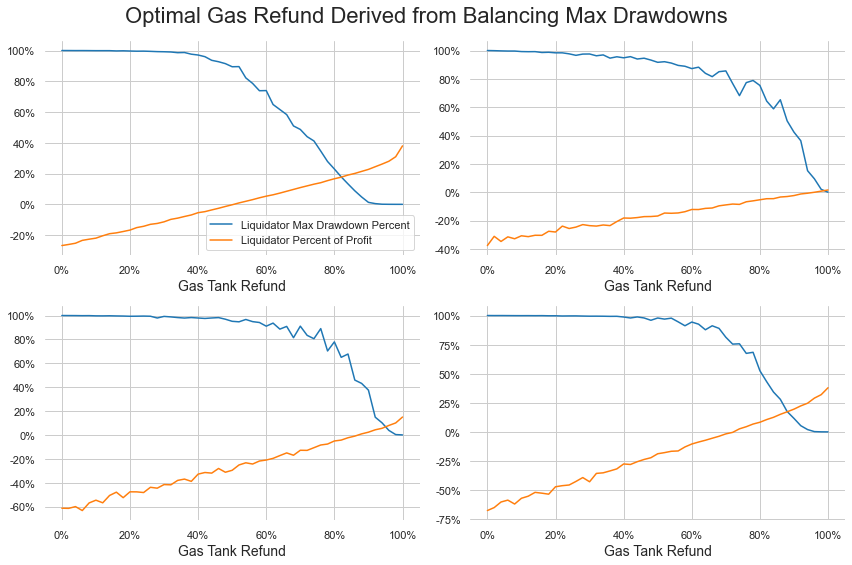

In [9]:
# for four random samples, show convergence points (note: only profitable inputs will converge)
fig, axs = plt.subplots(2,2, figsize=(12,8))
for i, ax in enumerate(axs.flat):
    params = sample_params()
    metrics_df = get_range_of_metrics(params)
    sns.lineplot(x='Refund Percentage', y='Liquidator Max Drawdown Percent', data=metrics_df, ax=ax, label='Liquidator Max Drawdown Percent')
    sns.lineplot(x='Refund Percentage', y='Liquidator Percent of Profit', data=metrics_df, ax=ax, label='Liquidator Percent of Profit')
    if i > 0:  # only le
        ax.get_legend().remove()
    
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x/100)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    ax.set_ylabel('', fontsize=6)
    ax.set_xlabel('Gas Tank Refund', fontsize=14)
    
    sns.despine(left=True, bottom=True)


fig.suptitle('Optimal Gas Refund Derived from Balancing Max Drawdowns', fontsize=22)
plt.tight_layout()
# plt.savefig('optimal_refund_percentage_grid.png', format='png')

## Show Visualization of Balanced Risk

In [24]:
# random example case 
params=sample_params()

In [25]:
params

{'upfront_fee': 0.04,
 'upfront_hours': 8.0,
 'monthly_opened_streams': 4128.300428456286,
 'average_stream_lifetime': 7.868480789901058,
 'percent_accidently_liquidated_per_month': 8.354679073691663,
 'average_stream_size': 4452.108994310144,
 'refund_rate': 0.11508014177062653,
 'min_self_liquidation_savings': 31.790802036524926,
 'gas_prediction_ability': 1.0537024416676282,
 'lowest_stream_cost_ratio': 3.2123301250438923,
 'distribution_inverse_skewness': 2.3821455845484065}

In [26]:
params['refund_rate'] = 0
df = simulate_and_calculate_pl(df, params)

In [27]:
zero_df = df.copy(deep=True)

In [28]:
params['refund_rate'] = 1
df = simulate_and_calculate_pl(df, params)

In [29]:
one_df = df.copy(deep=True)

In [30]:
params['refund_rate'] = get_optimal_refund_rate(calculate_and_return_loss, params)
df = simulate_and_calculate_pl(df, params)

In [31]:
balanced_df = df.copy(deep=True)

In [32]:
# show difference between three dfs
dfs = [zero_df, balanced_df, one_df]

In [33]:
colors = sns.color_palette("Set2")

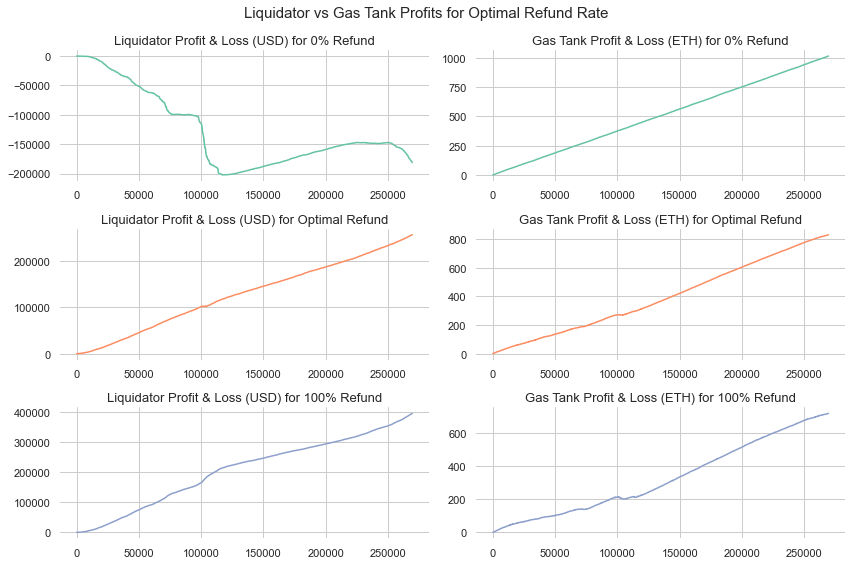

In [34]:
fig, axs = plt.subplots(3,2,figsize=(12,8))
titles = [' for 0% Refund', ' for Optimal Refund', ' for 100% Refund']
for i, ax in enumerate(axs.flat):
    local_df = dfs[i // 2]
    if i % 2 == 0:
        ax.plot(local_df['liquidator_pl'].cumsum(), color = colors[i // 2])
        ax.set_title('Liquidator Profit & Loss (USD)' + titles[i // 2], fontsize=13)
    else:
        ax.plot(local_df['gas_tank_eth_pl'].cumsum(), color = colors[i // 2])
        ax.set_title('Gas Tank Profit & Loss (ETH)' + titles[i // 2], fontsize=13)
    sns.despine(left=True, bottom=True)

fig.suptitle('Liquidator vs Gas Tank Profits for Optimal Refund Rate', fontsize=15)
plt.tight_layout()
# plt.savefig('liquidator_vs_gas_tank_optimal_refund2.png', format='png')

In [35]:
# read in AWS simulation outputs from run.py
files = [str(f) for f in Path('./sim_output').glob('**/*') if '.csv' in str(f)]

In [36]:
outputs = []
for f in files:
    outputs.append(pd.read_csv(f).drop(columns=['Unnamed: 0']))

In [38]:
df = pd.concat(outputs).reset_index(drop=True)

In [31]:
df['upfront_hours'].value_counts()

2.0     1205
0.5     1149
8.0     1143
1.0     1131
16.0    1089
4.0     1083
Name: upfront_hours, dtype: int64

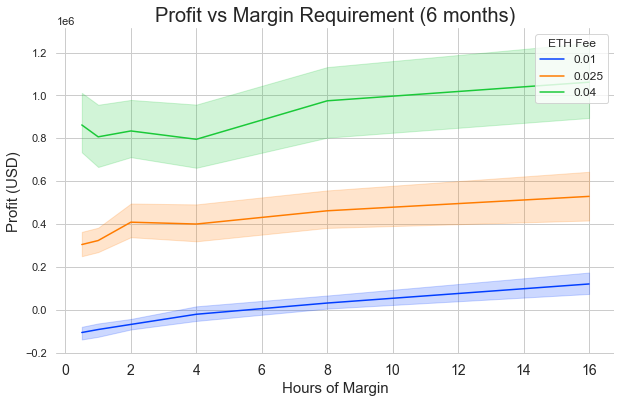

In [33]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
sns.lineplot(x='upfront_hours', y='total_profit', hue='upfront_fee', data=df, palette='bright', ci=99.5, legend=False)
ax.ticklabel_format(style='sci')
ax.set_xlabel('Hours of Margin', fontsize=15)
ax.set_ylabel('Profit (USD)', fontsize=15)
ax.set_title('Profit vs Margin Requirement (6 months)', fontsize=20)
plt.xticks(fontsize= 14)
sns.despine(left=True, bottom=True)
ax.legend(title='ETH Fee', loc='upper right', labels=['0.01', '0.025', '0.04'], fontsize=12)
plt.savefig('profit_vs_margin_requirements.png', format='png')
plt.show()

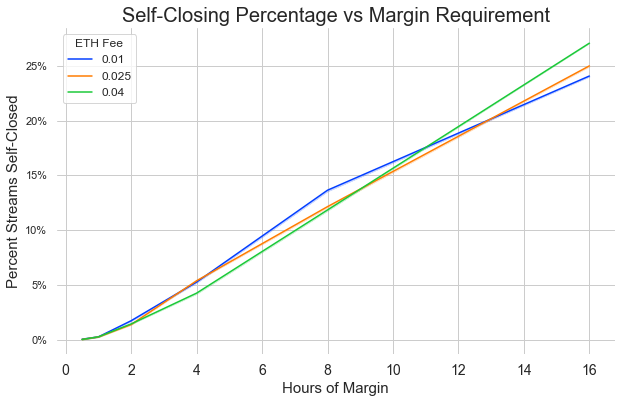

In [34]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
sns.lineplot(x='upfront_hours', y='percent_self_closed', hue='upfront_fee', data=df, palette='bright', ci=0, legend=False)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_xlabel('Hours of Margin', fontsize=15)
ax.set_ylabel('Percent Streams Self-Closed', fontsize=15)
ax.set_title('Self-Closing Percentage vs Margin Requirement', fontsize=20)
plt.xticks(fontsize= 14)
sns.despine(left=True, bottom=True)
ax.legend(title='ETH Fee', loc='upper left', labels=['0.01', '0.025', '0.04'], fontsize=12)
plt.savefig('self_closing_vs_margin_requirements.png', format='png')
plt.show()

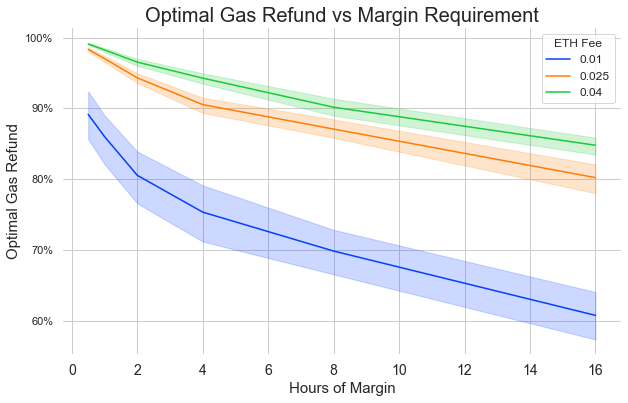

In [35]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
sns.lineplot(x='upfront_hours', y='refund_rate', hue='upfront_fee', data=df, palette='bright', ci=99.5, legend=False)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_xlabel('Hours of Margin', fontsize=15)
ax.set_ylabel('Optimal Gas Refund', fontsize=15)
ax.set_title('Optimal Gas Refund vs Margin Requirement', fontsize=20)
plt.xticks(fontsize= 14)
sns.despine(left=True, bottom=True)
ax.legend(title='ETH Fee', loc='upper right', labels=['0.01', '0.025', '0.04'], fontsize=12)
plt.savefig('gas_refund_vs_margin_requirements.png', format='png')
plt.show()

In [36]:
colors = sns.color_palette('bright')

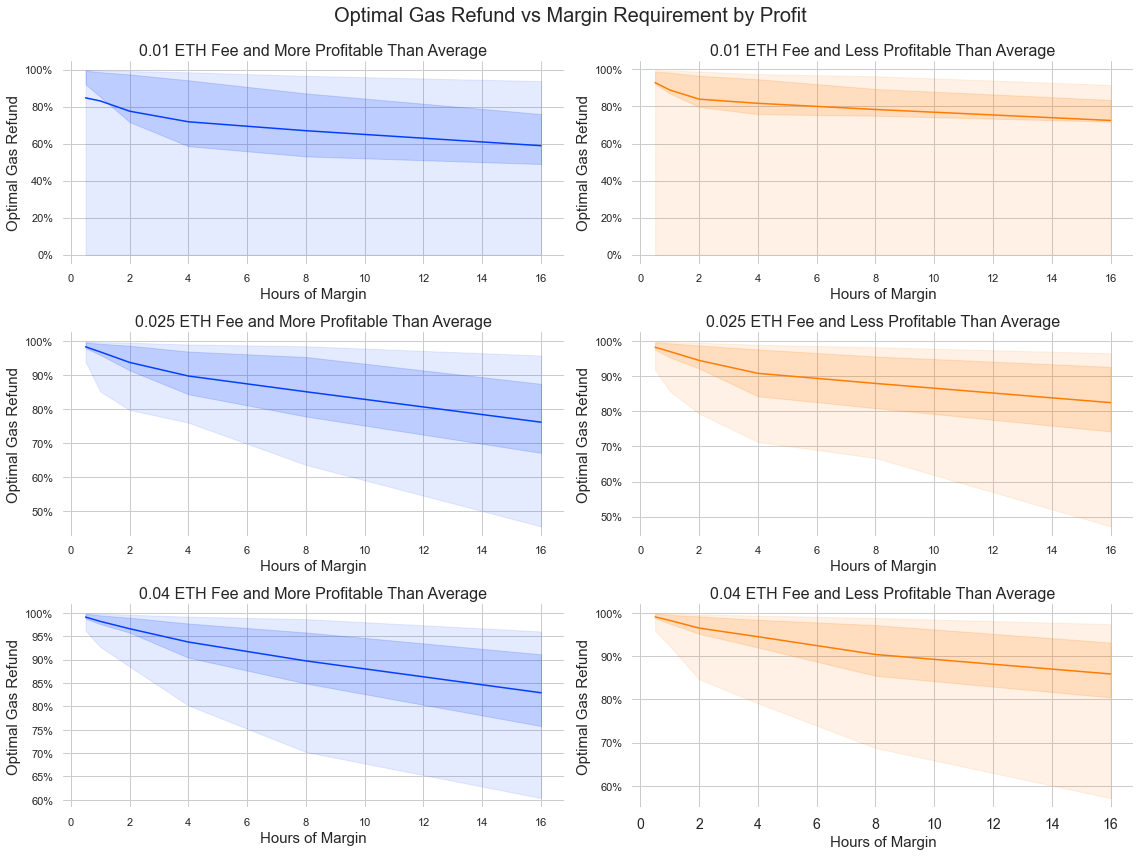

In [37]:
# showing the distribution...
fig, axs = plt.subplots(3,2,figsize=(16,12))
fees = [0.01, 0.025, 0.04]
for i, ax in enumerate(axs.flat):  # maybe compare 1 hour with 16 hours side by side
    fee = fees[i // 2]
    subset = df.loc[df['upfront_fee'] == fee].reset_index(drop=True)
    if i % 2 == 0:
        subset = subset.loc[subset['total_profit'] > np.mean(subset['total_profit'])].reset_index(drop=True)
        title = '{} ETH Fee and More Profitable Than Average'.format(fee)
    else:
        subset = subset.loc[subset['total_profit'] < np.mean(subset['total_profit'])].reset_index(drop=True)
        title = '{} ETH Fee and Less Profitable Than Average'.format(fee)
    
    sns.lineplot(x='upfront_hours', y='refund_rate', data=subset, palette='bright', ci=None, legend=False, ax=ax, color = colors[0 + 3*i%2])
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.set_xlabel('Hours of Margin', fontsize=15)
    ax.set_ylabel('Optimal Gas Refund', fontsize=15)
    ax.set_title(title, fontsize=16)

    bounds = subset.groupby('upfront_hours')['refund_rate'].quantile((0.01,0.99)).unstack()
    ax.fill_between(x=bounds.index,y1=bounds.iloc[:,0],y2=bounds.iloc[:,1],alpha=0.1, color=colors[0 + 3*i%2])

    bounds2 = subset.groupby('upfront_hours')['refund_rate'].quantile((0.25,0.75)).unstack()
    ax.fill_between(x=bounds2.index,y1=bounds2.iloc[:,0],y2=bounds2.iloc[:,1],alpha=0.17, color=colors[0 + 3*i%2])

    plt.xticks(fontsize= 14)
    sns.despine(left=True, bottom=True)
    # ax.legend(title='ETH Fee', loc='upper right', labels=['0.01', '0.025', '0.04'], fontsize=12)

fig.suptitle('Optimal Gas Refund vs Margin Requirement by Profit', fontsize=20, y=.99)
plt.tight_layout()
plt.savefig('gas_refund_vs_margin_requirements_by_profit.png', format='png')
plt.show()

## Play with the simulation inputs here

In [5]:
# read in gas price df
df = clean_imported_df(pd.read_csv('input_data.csv'))

In [6]:
# worst case
params = {'upfront_fee': 0.025,
 'upfront_hours': 8,
 'monthly_opened_streams': 100,
 'average_stream_lifetime': 3,
 'percent_accidently_liquidated_per_month': 0.5,
 'average_stream_size': 500,
 'refund_rate': 0.005948950114703533,
 'min_self_liquidation_savings': 0,
 'gas_prediction_ability': 0.5,
 'lowest_stream_cost_ratio': .8,
 'distribution_inverse_skewness': 1}

In [13]:
params['refund_rate'] = bisect(calculate_and_return_loss, .00001, .99999, args=params)

In [14]:
params

{'upfront_fee': 0.025,
 'upfront_hours': 8,
 'monthly_opened_streams': 100,
 'average_stream_lifetime': 3,
 'percent_accidently_liquidated_per_month': 0.5,
 'average_stream_size': 500,
 'refund_rate': 0.9375735638906183,
 'min_self_liquidation_savings': 0,
 'gas_prediction_ability': 0.5,
 'lowest_stream_cost_ratio': 0.8,
 'distribution_inverse_skewness': 1}

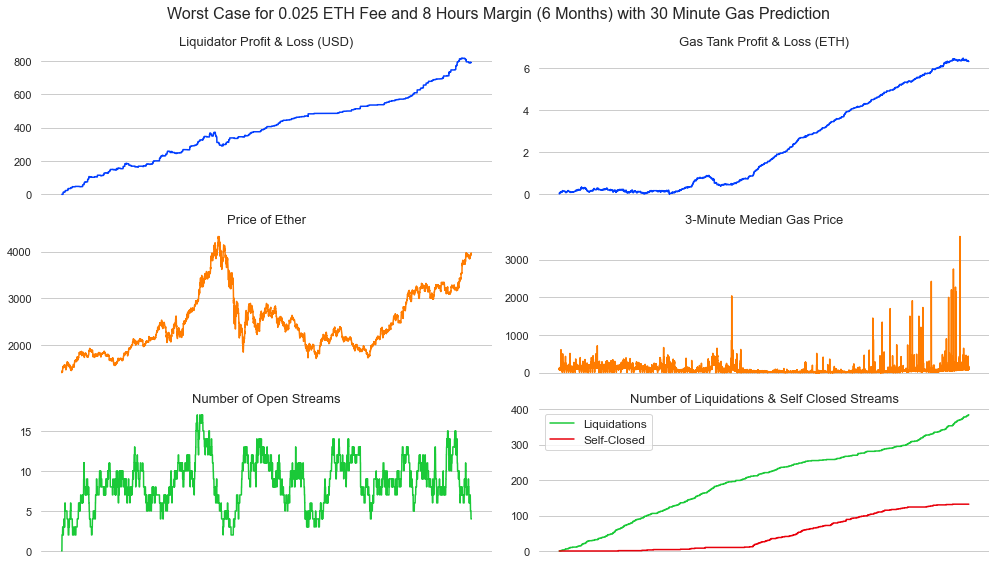

In [15]:
df = simulate_and_calculate_pl(df, params)
graph_pl(df, title='Worst Case for 0.025 ETH Fee and 8 Hours Margin (6 Months) with 30 Minute Gas Prediction')
plt.savefig('sim_run_highlights_025_and_8_worst_case_w_pred.png', format='png')

In [16]:
# best case
params = {'upfront_fee': 0.025,
 'upfront_hours': 8,
 'monthly_opened_streams': 5000,
 'average_stream_lifetime': 90,
 'percent_accidently_liquidated_per_month': 20,
 'average_stream_size': 5000,
 'refund_rate': 0.005948950114703533,
 'min_self_liquidation_savings': 30,
 'gas_prediction_ability': 0.5,  # 15 minutes
 'lowest_stream_cost_ratio': 3,
 'distribution_inverse_skewness': 4}

In [17]:
params['refund_rate'] = bisect(calculate_and_return_loss, .00001, .99999, args=params)

In [18]:
params

{'upfront_fee': 0.025,
 'upfront_hours': 8,
 'monthly_opened_streams': 5000,
 'average_stream_lifetime': 90,
 'percent_accidently_liquidated_per_month': 20,
 'average_stream_size': 5000,
 'refund_rate': 0.785511426283635,
 'min_self_liquidation_savings': 30,
 'gas_prediction_ability': 0.5,
 'lowest_stream_cost_ratio': 3,
 'distribution_inverse_skewness': 4}

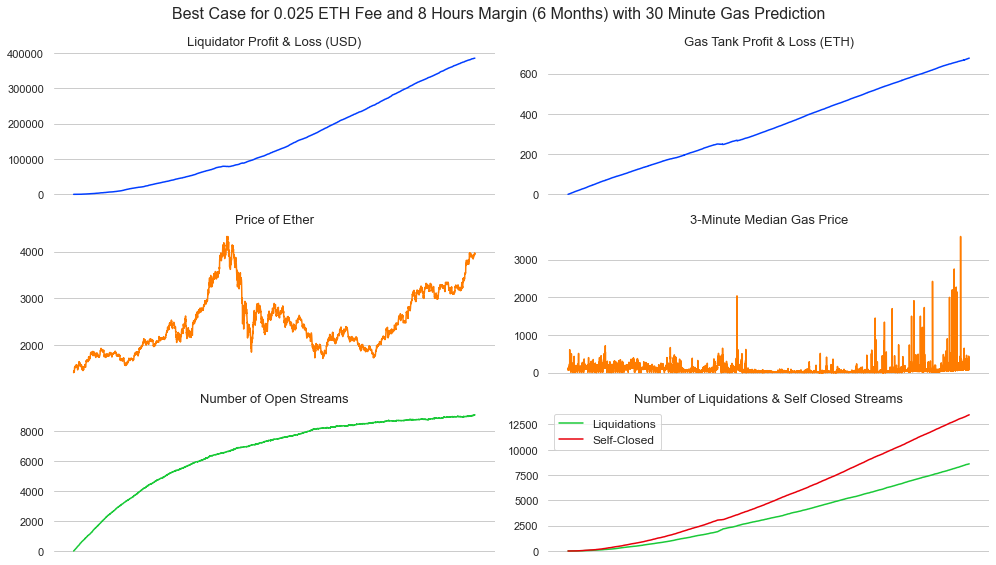

In [19]:
df = simulate_and_calculate_pl(df, params)
graph_pl(df, title='Best Case for 0.025 ETH Fee and 8 Hours Margin (6 Months) with 30 Minute Gas Prediction')
plt.savefig('sim_run_highlights_025_and_8_best_case_w_pred.png', format='png')

In [163]:
# notice that liquidations are generally a burden
params = {'upfront_fee': 0.001,
 'upfront_hours': 4,
 'monthly_opened_streams': 5000,
 'average_stream_lifetime': 90,
 'percent_accidently_liquidated_per_month': 3,
 'average_stream_size': 10000, # 10k makes money...
 'refund_rate': 0.005948950114703533,
 'min_self_liquidation_savings': 0,
 'gas_prediction_ability': 0,  # 15 minutes
 'lowest_stream_cost_ratio': 40,
 'distribution_inverse_skewness': 4}

In [164]:
params['refund_rate'] = get_optimal_refund_rate(calculate_and_return_loss, params)

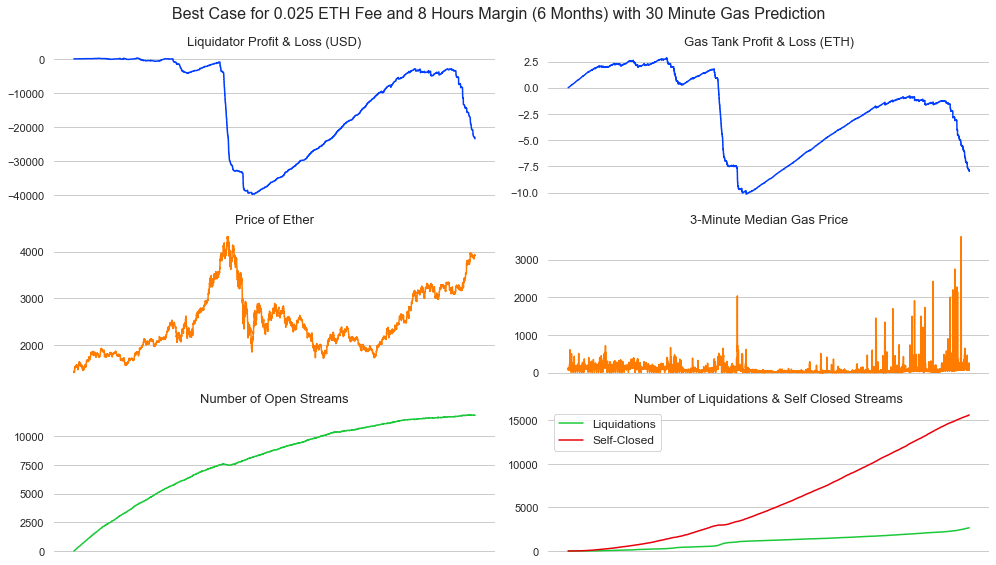

In [165]:
df = simulate_and_calculate_pl(df, params)
graph_pl(df, title='Best Case for 0.025 ETH Fee and 8 Hours Margin (6 Months) with 30 Minute Gas Prediction')

In [73]:
# layer 2
params = {'upfront_fee': 0,
 'upfront_hours': .5,
 'monthly_opened_streams': 5000,
 'average_stream_lifetime': 90,
 'percent_accidently_liquidated_per_month': .2,
 'average_stream_size': 1000, # 10k makes money...
 'refund_rate': 0,
 'min_self_liquidation_savings': 5,
 'gas_prediction_ability': 0,
 'lowest_stream_cost_ratio': 1,
 'distribution_inverse_skewness': .3}

In [62]:
# params['refund_rate'] = get_optimal_refund_rate(calculate_and_return_loss, params)

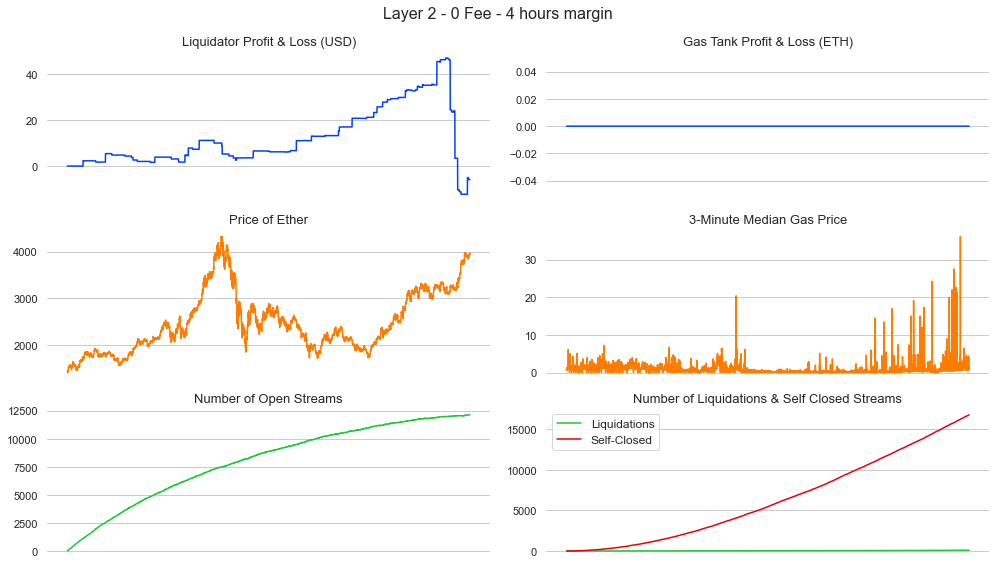

In [74]:
df = simulate_and_calculate_pl(df, params)
graph_pl(df, title='Layer 2 - 0 Fee - 4 hours margin')

In [ ]:
# solve for the number of upfront hours required to reasonably make a profit in most scenarios


In [25]:
df

,median_gas_price,price,three_min_median,n_opened,n_liquidated,n_self_closed,avg_liquidation_size,avg_self_closed_size,liquidator_pl,gas_refunded_eth,gas_tank_eth_pl,gas_tank_usd_pl
0,1.200000,1417.055653,1.020000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.020000,1416.776179,1.020000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.008000,1416.496704,1.008000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.048800,1416.217229,1.010000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.008000,1415.937755,1.008000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
269713,0.955894,3946.936866,0.948689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269714,0.894576,3947.009910,0.940000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269715,0.948689,3947.082953,0.948689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269716,0.940000,3947.155996,1.020000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

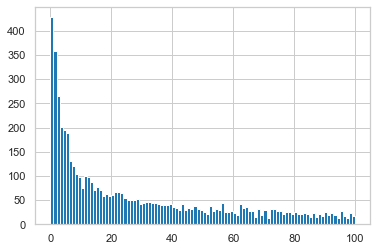

In [75]:
df.loc[(df['avg_self_closed_size'] > 0) & (df['avg_self_closed_size'] < 100), 'avg_self_closed_size'].hist(bins=100)

<AxesSubplot:>

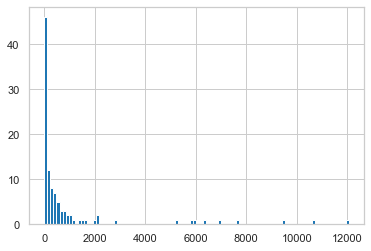

In [71]:
df.loc[df['avg_liquidation_size'] > 0, 'avg_liquidation_size'].hist(bins=100)

In [27]:
np.sum(df['avg_self_closed_size'])

83094127.92628048

<AxesSubplot:>

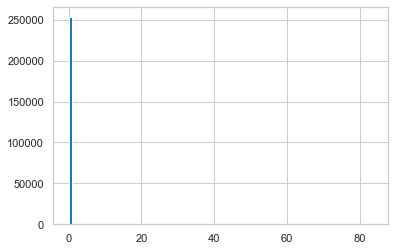

In [26]:
df.loc[df['avg_self_closed_size'] < 100, 'avg_self_closed_size'].hist(bins=100)